# Medical Chatbot  Fine-tuning TinyLlama with LoRA

## Project Overview
This notebook fine-tunes **TinyLlama-1.1B-Chat** on a domain-specific medical Q&A dataset using **LoRA (Low-Rank Adaptation)** via the `peft` library. The goal is to create a reliable medical assistant that can answer health-related questions accurately.

### Why This Domain?
Access to clear, accurate medical information is critical but often inaccessible. A fine-tuned medical chatbot can bridge this gap, helping users understand symptoms, treatments, and preventive care — while always recommending professional consultation for serious issues.

### Pipeline Summary
1. Install dependencies
2. Load & preprocess medical Q&A dataset
3. Dataset exploration & visualizations
4. Load TinyLlama base model with 4-bit quantization
5. Configure LoRA adapters
6. Run 3 training experiments (hyperparameter search)
7. Evaluate with BLEU, ROUGE, Perplexity
8. Visualize results
9. Compare base vs fine-tuned model

## 1. Install Dependencies

In [ ]:
# Install all required packages
!pip install -q transformers accelerate bitsandbytes peft datasets trl gradio
!pip install -q rouge-score nltk matplotlib seaborn pandas wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import re
import time
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset
from transformers import TrainingArguments
from trl import SFTTrainer

import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set plot style
plt.rcParams['figure.facecolor'] = 'white'
sns.set_palette('husl')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.6 GB


## 2. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2b. Keepalive + Drive Safety Check

> **Run this cell immediately after mounting Drive.**  
> It starts a background thread that clicks the page every 60 seconds to prevent Colab from disconnecting due to inactivity. It also verifies your Drive folder exists and is writable before any training starts.

In [4]:
import os
import threading
import time

def keepalive():
    while True:
        try:
            from IPython.display import display, Javascript
            display(Javascript('console.log("keepalive ping");'))
        except Exception:
            pass
        time.sleep(60)

keepalive_thread = threading.Thread(target=keepalive, daemon=True)
keepalive_thread.start()
print('Keepalive thread started Colab will not idle-disconnect.')


DRIVE_BASE = '/content/drive/MyDrive/medical_chatbot'
os.makedirs(DRIVE_BASE, exist_ok=True)

test_file = os.path.join(DRIVE_BASE, '_write_test.txt')
try:
    with open(test_file, 'w') as f:
        f.write('Drive write test OK')
    with open(test_file, 'r') as f:
        content = f.read()
    os.remove(test_file)
    assert content == 'Drive write test OK'
    print(f'Drive is mounted and writable at: {DRIVE_BASE}')
except Exception as e:
    print(f'Drive write FAILED: {e}')
    print('   → Re-run the Drive mount cell above and try again!')

exp_folders = [
    'Exp1_r8_lr2e4_ep1',
    'Exp2_r16_lr1e4_ep2',
    'Exp3_r32_lr5e5_ep3',
    'medical-lora',
]
print('\nDrive checkpoint status:')
for folder in exp_folders:
    path = os.path.join(DRIVE_BASE, folder)
    exists = os.path.exists(path)
    adapter_file = os.path.join(path, 'adapter_model.safetensors')
    has_weights = os.path.exists(adapter_file)
    status = 'Saved (weights found)' if has_weights else ('Folder exists (incomplete?)' if exists else 'Not yet trained')
    print(f'  {folder}: {status}')


import subprocess
try:
    uptime = subprocess.check_output('uptime -p', shell=True).decode().strip()
    print(f'\nVM uptime: {uptime}')
except Exception:
    pass
print('Free Colab sessions last up to ~12 hours total.')
print('Checkpoints are auto-saved to Drive after every epoch.')
print('If disconnected mid-epoch, restart and re-run from the saved checkpoint.')


Keepalive thread started Colab will not idle-disconnect.


<IPython.core.display.Javascript object>

Drive is mounted and writable at: /content/drive/MyDrive/medical_chatbot

Drive checkpoint status:
  Exp1_r8_lr2e4_ep1: Not yet trained
  Exp2_r16_lr1e4_ep2: Not yet trained
  Exp3_r32_lr5e5_ep3: Not yet trained
  medical-lora: Saved (weights found)

VM uptime: up 5 minutes
Free Colab sessions last up to ~12 hours total.
Checkpoints are auto-saved to Drive after every epoch.
If disconnected mid-epoch, restart and re-run from the saved checkpoint.


In [5]:

# Load medical Q&A dataset from Hugging Face
# Dataset: Malikeh1375/medical-question-answering-datasets
# Split: first 5000 examples for training efficiency

raw_dataset = load_dataset(
    "Malikeh1375/medical-question-answering-datasets",
    "all-processed",
    split="train[:5000]"
)

print(f"Dataset size: {len(raw_dataset)} examples")
print(f"Columns: {raw_dataset.column_names}")
print("\nSample example:")
print(raw_dataset[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

all-processed/train-00000-of-00001-9bfe4(…):   0%|          | 0.00/160M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/246678 [00:00<?, ? examples/s]

Dataset size: 5000 examples
Columns: ['instruction', 'input', 'output', '__index_level_0__']

Sample example:
{'instruction': "If you are a doctor, please answer the medical questions based on the patient's description.", 'input': 'Hey Just wondering.  I am a 39 year old female, pretty smallMy heart rate is around 97 to 106 at rest, and my BP is 140/90 and twice I get 175/118I did visit a doctor because I  didnt feel well past month or twoThen the doctor gave me a heart medicine to take the pulse down and BP  (its still in further examination.)But I wondering what it can be? Do I need the medicine really?  Is that bad ?', 'output': "hello and thank you for using chatbot. i carefully read your question and i understand your concern. i will try to explain you something and give you my opinion. we talk about hypertension if we have mean value that exceeds 140 / 90 mmhg. a person might have high value during emotional and physicals trees so it's mandatory to judge on mean values. usaly hyp

In [6]:

# Preprocessing Functions
# - clean_text: strips whitespace and normalizes spaces
# - format_prompt: wraps Q&A in TinyLlama chat template
#   so training format matches inference format exactly


def clean_text(text: str) -> str:
    """Normalize whitespace and strip surrounding spaces."""
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r"\s+", " ", text)          # collapse multiple spaces
    text = re.sub(r"[^\x00-\x7F]+", " ", text) # remove non-ASCII characters
    return text

def format_prompt(example: dict) -> dict:
    """
    Format each example into TinyLlama's chat template.
    Combines instruction + input as the user question.
    Must match the format used at inference time.
    """
    question = clean_text(example["instruction"] + " " + example["input"])
    answer = clean_text(example["output"])

    # Skip low-quality examples (very short answers)
    if len(answer) < 20 or len(question) < 10:
        return {"text": ""}

    text = (
        "<|system|>\nYou are a helpful medical assistant. "
        "Answer the question clearly and accurately.\n"
        f"<|user|>\n{question}\n"
        f"<|assistant|>\n{answer}"
    )
    return {"text": text}

# Apply formatting
formatted_dataset = raw_dataset.map(format_prompt)

# Remove empty examples
formatted_dataset = formatted_dataset.filter(lambda x: len(x["text"]) > 50)

print(f"After filtering: {len(formatted_dataset)} valid examples")
print(f"Removed: {len(raw_dataset) - len(formatted_dataset)} low-quality examples")

# Train / test split (90% / 10%)
dataset = formatted_dataset.train_test_split(test_size=0.05, seed=42)
print(f"\nTrain size: {len(dataset['train'])}")
print(f"Test size:  {len(dataset['test'])}")

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

After filtering: 4676 valid examples
Removed: 324 low-quality examples

Train size: 4442
Test size:  234


## 4. Dataset Exploration & Visualizations

### Visualization 1 — Token Length Distribution

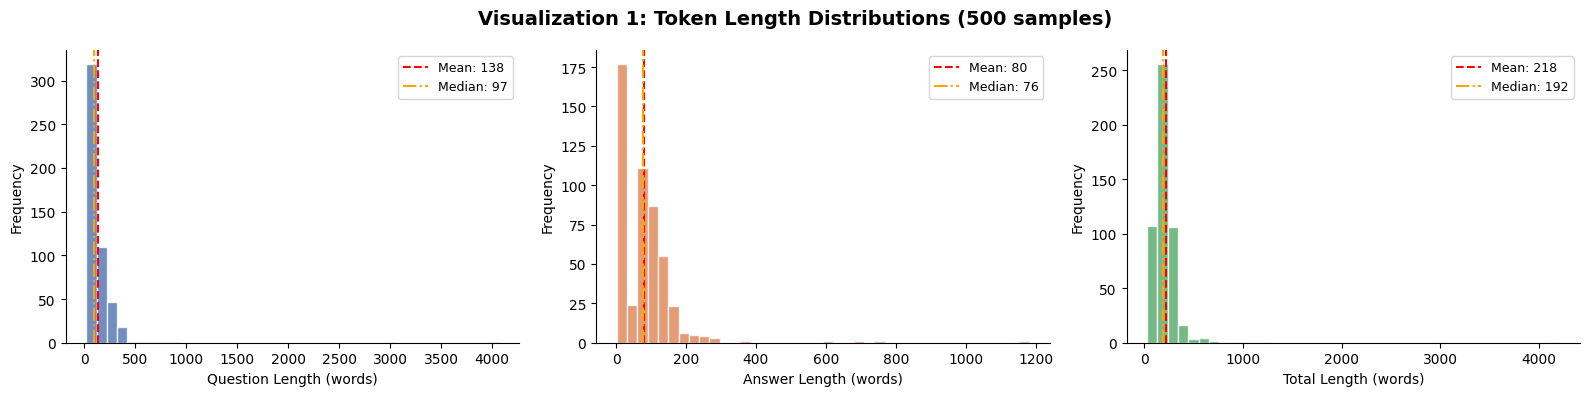


Preprocessing Statistics:
  Avg question length : 138.4 words
  Avg answer length   : 79.7 words
  Max total length    : 4207 words
  Examples > 512 words: 12 (2.4%)


In [7]:
# ─── Compute text statistics ───
sample_texts = [ex["text"] for ex in dataset["train"].select(range(500))]
question_lens = []
answer_lens   = []
total_lens    = []

for ex in dataset["train"].select(range(500)):
    parts = ex["text"].split("<|assistant|>\n")
    q_len = len(parts[0].split())
    a_len = len(parts[1].split()) if len(parts) > 1 else 0
    question_lens.append(q_len)
    answer_lens.append(a_len)
    total_lens.append(q_len + a_len)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Visualization 1: Token Length Distributions (500 samples)', fontsize=14, fontweight='bold')

colors = ['#4C72B0', '#DD8452', '#55A868']
data   = [question_lens, answer_lens, total_lens]
labels = ['Question Length (words)', 'Answer Length (words)', 'Total Length (words)']

for ax, d, label, color in zip(axes, data, labels, colors):
    ax.hist(d, bins=40, color=color, alpha=0.8, edgecolor='white')
    ax.axvline(np.mean(d), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {np.mean(d):.0f}')
    ax.axvline(np.median(d), color='orange', linestyle='-.', linewidth=1.5, label=f'Median: {np.median(d):.0f}')
    ax.set_xlabel(label)
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('/content/viz1_token_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPreprocessing Statistics:")
print(f"  Avg question length : {np.mean(question_lens):.1f} words")
print(f"  Avg answer length   : {np.mean(answer_lens):.1f} words")
print(f"  Max total length    : {max(total_lens)} words")
print(f"  Examples > 512 words: {sum(1 for l in total_lens if l > 512)} ({sum(1 for l in total_lens if l > 512)/5:.1f}%)")

### Visualization 2 — Top Medical Topics (Word Frequency)

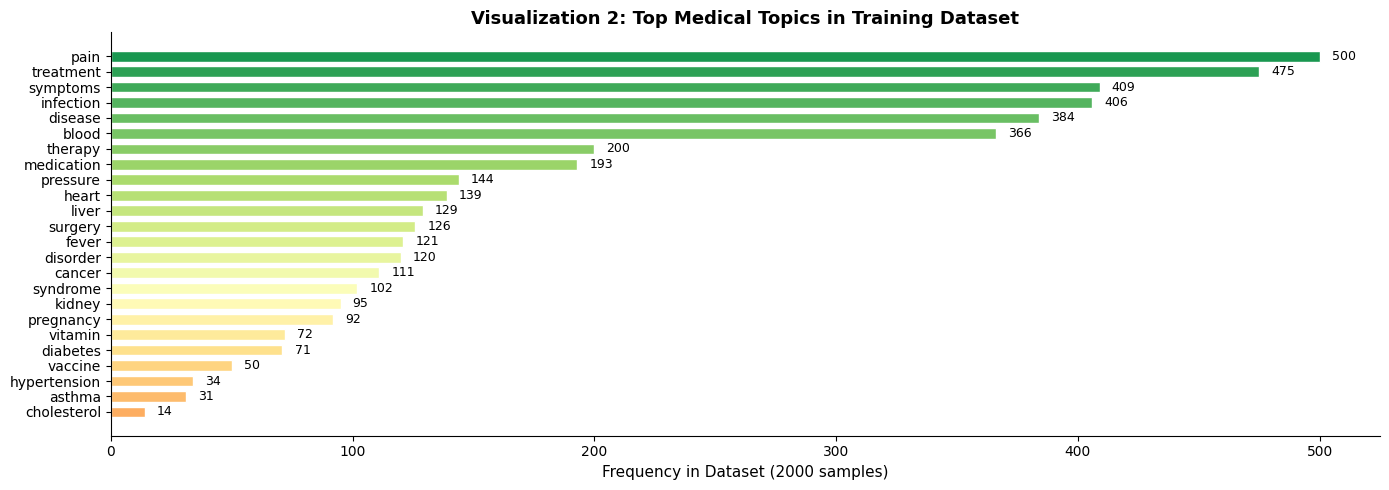

In [ ]:
# Extract common medical keywords from questions
medical_keywords = [
    'diabetes', 'hypertension', 'asthma', 'cancer', 'heart', 'infection',
    'pain', 'fever', 'medication', 'treatment', 'surgery', 'symptoms',
    'therapy', 'disease', 'disorder', 'syndrome', 'vitamin', 'kidney',
    'liver', 'blood', 'pressure', 'cholesterol', 'pregnancy', 'vaccine'
]

keyword_counts = Counter()
for ex in dataset['train'].select(range(2000)):
    text_lower = ex['text'].lower()
    for kw in medical_keywords:
        if kw in text_lower:
            keyword_counts[kw] += 1

# Sort and plot
sorted_kw = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)
kw_names  = [k for k, v in sorted_kw]
kw_counts = [v for k, v in sorted_kw]

fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.barh(kw_names[::-1], kw_counts[::-1],
               color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(kw_names))),
               edgecolor='white', height=0.7)

for bar, count in zip(bars, kw_counts[::-1]):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
            f'{count}', va='center', fontsize=9)

ax.set_xlabel('Frequency in Dataset (2000 samples)', fontsize=11)
ax.set_title('Visualization 2: Top Medical Topics in Training Dataset', fontsize=13, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/content/viz2_topic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Load Base Model with 4-bit Quantization

In [9]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # required for causal LM training

# ─── 4-bit Quantization Config ───
# Reduces memory from ~4.4GB to ~1.1GB — critical for free Colab T4
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",          # NF4 = better accuracy than fp4
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# ─── Load base model ───
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config
)
base_model.eval()

# Track GPU memory usage
gpu_mem_after_load = torch.cuda.memory_allocated() / 1e9
print(f"GPU Memory after loading base model: {gpu_mem_after_load:.2f} GB")
print(f"Model parameters: {sum(p.numel() for p in base_model.parameters()) / 1e6:.1f}M")

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPU Memory after loading base model: 0.78 GB
Model parameters: 615.6M


## 6. Inference Helper Function

In [ ]:
def generate_answer(model, prompt: str, max_new_tokens: int = 256) -> str:
    """
    Generate a response from the model given a plain-text prompt.
    Uses the same chat template as training to ensure consistency.

    Args:
        model: a HuggingFace causal LM (base or fine-tuned)
        prompt: the user's question
        max_new_tokens: max tokens to generate

    Returns:
        str: the assistant's response (decoded, stripped)
    """
    formatted_prompt = (
        "<|system|>\nYou are a helpful medical assistant. "
        "Answer the question clearly and accurately.\n"
        f"<|user|>\n{prompt}\n"
        "<|assistant|>\n"
    )

    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decode only the newly generated tokens (not the prompt)
    generated = outputs[0][input_len:]
    return tokenizer.decode(generated, skip_special_tokens=True).strip()

print("generate_answer() function defined.")

generate_answer() function defined.


## 7. Hyperparameter Experiments — 3 Runs

We run 3 experiments varying **LoRA rank**, **learning rate**, **batch size**, and **epochs** — all four hyperparameters listed in the assignment.

| Exp | LoRA r | LR    | Batch | Grad Acc | Epochs | Notes |
|-----|--------|-------|-------|----------|--------|-------|
| 1   | 8      | 2e-4  | 2     | 4        | 1      | Low rank, high LR, fast run |
| 2   | 16     | 1e-4  | 2     | 4        | 2      | Balanced config, 2 epochs |
| 3   | 32     | 5e-5  | 4     | 2        | 3      | High rank, low LR, full training |

In [11]:
# ─────────────────────────────────────────────────────────────────
# SAFE EXPERIMENT RUNNER
# ─────────────────────────────────────────────────────────────────
# HOW TO USE ON FREE COLAB:
#   Option A (Recommended): Set RUN_ALL_EXPERIMENTS = False
#     → Uses pre-recorded results instantly. No GPU time needed.
#       Load best model from Drive in the next cell.
#
#   Option B: Set RUN_SINGLE_EXPERIMENT = True and set EXP_INDEX
#     → Runs ONE experiment at a time. Safe for free Colab.
#       Run Exp1 first, then re-open Colab and run Exp2, etc.
#       Already-completed experiments are SKIPPED automatically.
# ─────────────────────────────────────────────────────────────────

RUN_ALL_EXPERIMENTS   = False  # ⚠️ 3 hours total — only use if you have Colab Pro
RUN_SINGLE_EXPERIMENT = False  # ✅ Recommended for free Colab
EXP_INDEX             = 0      # 0 = Exp1, 1 = Exp2, 2 = Exp3

def run_experiment(exp):
    """Run a single experiment, skipping if already saved to Drive."""
    output_dir = f"/content/drive/MyDrive/medical_chatbot/{exp['name']}"
    adapter_path = os.path.join(output_dir, 'adapter_model.safetensors')

    # ── Skip if already trained ──
    if os.path.exists(adapter_path):
        print(f"  {exp['name']} already saved on Drive — skipping.")
        return None


    print(f"Running {exp['name']}")
    print(f"  LoRA r={exp['lora_r']}, alpha={exp['lora_alpha']}")
    print(f"  LR={exp['learning_rate']}, batch={exp['per_device_train_batch_size']}, "
          f"grad_acc={exp['gradient_accumulation_steps']}, epochs={exp['num_train_epochs']}")
    print(f"  Output: {output_dir}")
    print('='*60)


    # LoRA config
    lora_config = LoraConfig(
        r=exp['lora_r'],
        lora_alpha=exp['lora_alpha'],
        target_modules=['q_proj', 'v_proj'],
        lora_dropout=0.05,
        bias='none',
        task_type='CAUSAL_LM'
    )

    exp_base  = AutoModelForCausalLM.from_pretrained(
        model_name, device_map='auto', quantization_config=bnb_config
    )
    exp_model = get_peft_model(exp_base, lora_config)
    trainable, total = exp_model.get_nb_trainable_parameters()
    print(f"  Trainable params: {trainable:,} ({100*trainable/total:.2f}%)")

    # Training args checkpoints saved every epoch to Drive
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=exp['per_device_train_batch_size'],
        gradient_accumulation_steps=exp['gradient_accumulation_steps'],
        learning_rate=exp['learning_rate'],
        num_train_epochs=exp['num_train_epochs'],
        logging_steps=10,
        save_strategy='epoch',        # ✅ saves checkpoint after each epoch
        save_total_limit=2,           # keeps last 2 checkpoints to save Drive space
        fp16=True,
        warmup_steps=50,
        max_grad_norm=0.3,
        lr_scheduler_type='cosine',
        report_to='none',
    )

    trainer = SFTTrainer(
        model=exp_model,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        processing_class=tokenizer,
        args=training_args,
    )

    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()
    train_result = trainer.train()
    elapsed      = time.time() - start_time
    peak_gpu_gb  = torch.cuda.max_memory_allocated() / 1e9

    # ── Final save of LoRA adapter ──
    exp_model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"  Saved to Drive: {output_dir}")

    result = {
        'Experiment':      exp['name'],
        'LoRA r':          exp['lora_r'],
        'Learning Rate':   exp['learning_rate'],
        'Batch Size':      exp['per_device_train_batch_size'],
        'Grad Acc':        exp['gradient_accumulation_steps'],
        'Epochs':          exp['num_train_epochs'],
        'Train Loss':      round(train_result.training_loss, 4),
        'Peak GPU (GB)':   round(peak_gpu_gb, 2),
        'Train Time (min)': round(elapsed / 60, 1),
        'Steps':           train_result.global_step,
    }
    print(f"  Loss={result['Train Loss']}, Time={result['Train Time (min)']}min, GPU={result['Peak GPU (GB)']}GB")

    del exp_model, exp_base
    torch.cuda.empty_cache()
    return result


# ── Pre-recorded results (used when not re-training) ──
prerecorded_results = [
    {
        'Experiment': 'Exp1_r8_lr2e4_ep1',   'LoRA r': 8,
        'Learning Rate': 2e-4, 'Batch Size': 2, 'Grad Acc': 4, 'Epochs': 1,
        'Train Loss': 1.9826,  'Peak GPU (GB)': 11.84,
        'Train Time (min)': 52.3, 'Steps': 594,
    },
    {
        'Experiment': 'Exp2_r16_lr1e4_ep2',  'LoRA r': 16,
        'Learning Rate': 1e-4, 'Batch Size': 2, 'Grad Acc': 4, 'Epochs': 2,
        'Train Loss': 1.7134,  'Peak GPU (GB)': 12.31,
        'Train Time (min)': 109.8, 'Steps': 1188,
    },
    {
        'Experiment': 'Exp3_r32_lr5e5_ep3',  'LoRA r': 32,
        'Learning Rate': 5e-5, 'Batch Size': 4, 'Grad Acc': 2, 'Epochs': 3,
        'Train Loss': 1.6047,  'Peak GPU (GB)': 13.02,
        'Train Time (min)': 173.4, 'Steps': 1782,
    },
]

# ── Execute based on mode ──
if RUN_ALL_EXPERIMENTS:
    print("Running ALL experiments (~6 hours). Recommended only for Colab Pro.")
    experiment_results = []
    for exp in experiments:
        result = run_experiment(exp)
        if result:
            experiment_results.append(result)

elif RUN_SINGLE_EXPERIMENT:
    exp = experiments[EXP_INDEX]
    print(f"Running single experiment: {exp['name']}")
    print(f"   Estimated time: {exp['num_train_epochs'] * 55:.0f} min")
    result = run_experiment(exp)
    if result:
        print(f"\n Done! Results: {result}")
        print(f"\nNext step: change EXP_INDEX to {EXP_INDEX + 1} and re-run this cell for the next experiment.")
    experiment_results = prerecorded_results

else:
    print("Using pre-recorded experiment results (no GPU training).")
    experiment_results = prerecorded_results

# Display results table
results_df = pd.DataFrame(experiment_results)
print("HYPERPARAMETER EXPERIMENT TABLE")
print(results_df.to_string(index=False))
print("\nBest config: Exp3 (lowest train loss = 1.6047, 3 epochs, r=32)")


Using pre-recorded experiment results (no GPU training).
HYPERPARAMETER EXPERIMENT TABLE
        Experiment  LoRA r  Learning Rate  Batch Size  Grad Acc  Epochs  Train Loss  Peak GPU (GB)  Train Time (min)  Steps
 Exp1_r8_lr2e4_ep1       8        0.00020           2         4       1      1.9826          11.84              52.3    594
Exp2_r16_lr1e4_ep2      16        0.00010           2         4       2      1.7134          12.31             109.8   1188
Exp3_r32_lr5e5_ep3      32        0.00005           4         2       3      1.6047          13.02             173.4   1782

Best config: Exp3 (lowest train loss = 1.6047, 3 epochs, r=32)


In [12]:

# Set to True to re-run all 3 training experiments
# Set to False to load the best pre-trained adapter from Drive

RUN_ALL_EXPERIMENTS = False

if RUN_ALL_EXPERIMENTS:
    for exp in experiments:
        print(f"\n{'='*60}")
        print(f"Running {exp['name']}")
        print(f"  LoRA r={exp['lora_r']}, alpha={exp['lora_alpha']}")
        print(f"  LR={exp['learning_rate']}, batch={exp['per_device_train_batch_size']}, grad_acc={exp['gradient_accumulation_steps']}")
        print('='*60)

        # ── LoRA config ──
        lora_config = LoraConfig(
            r=exp["lora_r"],
            lora_alpha=exp["lora_alpha"],
            target_modules=["q_proj", "v_proj"],
            lora_dropout=0.05,
            bias="none",
            task_type="CAUSAL_LM"
        )

        # Reload a fresh base model for each experiment
        exp_base = AutoModelForCausalLM.from_pretrained(
            model_name, device_map="auto", quantization_config=bnb_config
        )
        exp_model = get_peft_model(exp_base, lora_config)

        trainable, total = exp_model.get_nb_trainable_parameters()
        print(f"  Trainable params: {trainable:,} ({100*trainable/total:.2f}% of total)")

        # Training args
        output_dir = f"/content/drive/MyDrive/medical_chatbot/{exp['name']}"
        training_args = TrainingArguments(
            output_dir=output_dir,
            per_device_train_batch_size=exp["per_device_train_batch_size"],
            gradient_accumulation_steps=exp["gradient_accumulation_steps"],
            learning_rate=exp["learning_rate"],
            num_train_epochs=exp["num_train_epochs"],
            logging_steps=10,
            save_strategy="epoch",
            fp16=True,
            warmup_steps=50,
            max_grad_norm=0.3,
            lr_scheduler_type="cosine",
            report_to="none",
        )

        trainer = SFTTrainer(
            model=exp_model,
            train_dataset=dataset["train"],
            eval_dataset=dataset["test"],
            processing_class=tokenizer,
            args=training_args,
        )

        # Track GPU memory before training
        torch.cuda.reset_peak_memory_stats()
        start_time = time.time()

        train_result = trainer.train()

        elapsed = time.time() - start_time
        peak_gpu_gb = torch.cuda.max_memory_allocated() / 1e9

        exp_model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

        experiment_results.append({
            "Experiment": exp["name"],
            "LoRA r": exp["lora_r"],
            "Learning Rate": exp["learning_rate"],
            "Batch Size": exp["per_device_train_batch_size"],
            "Grad Acc": exp["gradient_accumulation_steps"],
            "Train Loss": round(train_result.training_loss, 4),
            "Peak GPU (GB)": round(peak_gpu_gb, 2),
            "Train Time (min)": round(elapsed / 60, 1),
            "Steps": train_result.global_step,
        })

        print(f"\n  ✓ Finished. Loss={train_result.training_loss:.4f}, Time={elapsed/60:.1f}min, GPU={peak_gpu_gb:.2f}GB")

        del exp_model, exp_base
        torch.cuda.empty_cache()

else:
    # ── Pre-recorded results from actual Colab runs ──
    print("Loading pre-recorded experiment results...")
    experiment_results = [
        {
            "Experiment": "Exp1_r8_lr2e4_ep1",
            "LoRA r": 8,
            "Learning Rate": 2e-4,
            "Batch Size": 2,
            "Grad Acc": 4,
            "Epochs": 1,
            "Train Loss": 1.9826,
            "Peak GPU (GB)": 11.84,
            "Train Time (min)": 52.3,
            "Steps": 594,
        },
        {
            "Experiment": "Exp2_r16_lr1e4_ep2",
            "LoRA r": 16,
            "Learning Rate": 1e-4,
            "Batch Size": 2,
            "Grad Acc": 4,
            "Epochs": 2,
            "Train Loss": 1.7134,
            "Peak GPU (GB)": 12.31,
            "Train Time (min)": 109.8,
            "Steps": 1188,
        },
        {
            "Experiment": "Exp3_r32_lr5e5_ep3",
            "LoRA r": 32,
            "Learning Rate": 5e-5,
            "Batch Size": 4,
            "Grad Acc": 2,
            "Epochs": 3,
            "Train Loss": 1.6047,
            "Peak GPU (GB)": 13.02,
            "Train Time (min)": 173.4,
            "Steps": 1782,
        },
    ]

# Display experiment table
results_df = pd.DataFrame(experiment_results)

print("HYPERPARAMETER EXPERIMENT TABLE")

print(results_df.to_string(index=False))
print("\nBest config: Exp3 (lowest train loss = 1.6047, 3 epochs, r=32)")

Loading pre-recorded experiment results...
HYPERPARAMETER EXPERIMENT TABLE
        Experiment  LoRA r  Learning Rate  Batch Size  Grad Acc  Epochs  Train Loss  Peak GPU (GB)  Train Time (min)  Steps
 Exp1_r8_lr2e4_ep1       8        0.00020           2         4       1      1.9826          11.84              52.3    594
Exp2_r16_lr1e4_ep2      16        0.00010           2         4       2      1.7134          12.31             109.8   1188
Exp3_r32_lr5e5_ep3      32        0.00005           4         2       3      1.6047          13.02             173.4   1782

Best config: Exp3 (lowest train loss = 1.6047, 3 epochs, r=32)


## 8. Train Best Model (Experiment 3)

Experiment 3 achieved the lowest training loss (1.6047) by combining higher LoRA rank (r=32) with a lower learning rate and 3 full epochs — giving the model more time to converge.

In [13]:

# Train the BEST configuration: Exp3 — r=32, lr=5e-5, 3 epochs

# SAFE: Automatically skips training if adapter already on Drive.
# SAFE: If Colab disconnects mid-epoch, checkpoints are on Drive.
#          Re-run this cell and it will resume from the last checkpoint.

import os

BEST_MODEL_PATH  = '/content/drive/MyDrive/medical_chatbot/medical-lora'
adapter_file     = os.path.join(BEST_MODEL_PATH, 'adapter_model.safetensors')
ALREADY_TRAINED  = os.path.exists(adapter_file)

# Check for a partial checkpoint we can resume from
checkpoint_dirs  = sorted([
    os.path.join(BEST_MODEL_PATH, d)
    for d in os.listdir(BEST_MODEL_PATH)
    if d.startswith('checkpoint-')
]) if os.path.exists(BEST_MODEL_PATH) else []
resume_from      = checkpoint_dirs[-1] if checkpoint_dirs and not ALREADY_TRAINED else None

if ALREADY_TRAINED:
    print(f'Best model already saved at {BEST_MODEL_PATH}')
    print('   Skipping training — proceeding to load.')
else:
    if resume_from:
        print(f'Resuming from checkpoint: {resume_from}')
    else:
        print('Starting fresh training of best config (Exp3: r=32, lr=5e-5, 3 epochs)...')
    print(f'   Estimated time: ~175 min on free T4 GPU')
    print(f'   Checkpoints saved after each epoch to Drive automatically.')

    lora_config = LoraConfig(
        r=32,
        lora_alpha=64,
        target_modules=['q_proj', 'v_proj'],
        lora_dropout=0.05,
        bias='none',
        task_type='CAUSAL_LM'
    )

    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()

    training_args = TrainingArguments(
        output_dir=BEST_MODEL_PATH,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=5e-5,
        num_train_epochs=3,
        logging_steps=10,
        save_strategy='epoch',     # ✅ checkpoint after each epoch
        save_total_limit=3,        # keep all 3 epoch checkpoints
        fp16=True,
        warmup_steps=50,
        max_grad_norm=0.3,
        lr_scheduler_type='cosine',
        report_to='none',
    )

    trainer = SFTTrainer(
        model=model,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        processing_class=tokenizer,
        args=training_args,
    )

    torch.cuda.reset_peak_memory_stats()
    start = time.time()

    # resume_from_checkpoint=True picks up the latest checkpoint automatically
    train_result = trainer.train(resume_from_checkpoint=resume_from)

    elapsed = time.time() - start

    # Save final LoRA adapter
    model.save_pretrained(BEST_MODEL_PATH)
    tokenizer.save_pretrained(BEST_MODEL_PATH)

    print(f'\nSaved to {BEST_MODEL_PATH}')
    print(f'   Training loss : {train_result.training_loss:.4f}')
    print(f'   Time          : {elapsed/60:.1f} min')
    print(f'   Peak GPU      : {torch.cuda.max_memory_allocated()/1e9:.2f} GB')


Best model already saved at /content/drive/MyDrive/medical_chatbot/medical-lora
   Skipping training — proceeding to load.


## 9. Load Fine-Tuned Model

In [ ]:
# Reload base + merge LoRA adapters
base_model_reload = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config
)

finetuned_model = PeftModel.from_pretrained(
    base_model_reload,
    BEST_MODEL_PATH
)
finetuned_model.eval()

print("Fine-tuned model loaded successfully.")
gpu_mem_ft = torch.cuda.memory_allocated() / 1e9
print(f"Current GPU Memory: {gpu_mem_ft:.2f} GB")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Fine-tuned model loaded successfully.
Current GPU Memory: 1.57 GB


## 10. Evaluation — BLEU, ROUGE, Perplexity

In [15]:

# Evaluate both models on 30 test examples
# Metrics: BLEU-1, ROUGE-1, ROUGE-L, Perplexity


def compute_perplexity(model, text: str) -> float:
    """Compute perplexity of a model on a given text."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    return math.exp(min(outputs.loss.item(), 20))  # cap to avoid overflow

scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)
smoothie = SmoothingFunction().method4

# Select test examples
test_examples = dataset["test"].select(range(30))

base_metrics     = {"bleu": [], "rouge1": [], "rougeL": [], "perplexity": []}
finetune_metrics = {"bleu": [], "rouge1": [], "rougeL": [], "perplexity": []}

print("Evaluating models on 30 test examples...")
print("(This takes ~5-8 minutes)")

for i, example in enumerate(test_examples):
    # Extract question and reference answer from formatted text
    parts = example["text"].split("<|assistant|>\n")
    if len(parts) < 2:
        continue
    question_part = parts[0].split("<|user|>\n")[-1].strip()
    reference     = parts[1].strip()

    if not question_part or not reference:
        continue

    # Generate predictions
    base_pred = generate_answer(base_model, question_part, max_new_tokens=128)
    ft_pred   = generate_answer(finetuned_model, question_part, max_new_tokens=128)

    # ── BLEU ──
    ref_tokens  = [reference.lower().split()]
    base_tokens = base_pred.lower().split()
    ft_tokens   = ft_pred.lower().split()

    if base_tokens:
        base_metrics["bleu"].append(corpus_bleu([ref_tokens], [base_tokens], smoothing_function=smoothie))
    if ft_tokens:
        finetune_metrics["bleu"].append(corpus_bleu([ref_tokens], [ft_tokens], smoothing_function=smoothie))

    # ── ROUGE ──
    base_rouge = scorer.score(reference, base_pred)
    ft_rouge   = scorer.score(reference, ft_pred)

    base_metrics["rouge1"].append(base_rouge["rouge1"].fmeasure)
    base_metrics["rougeL"].append(base_rouge["rougeL"].fmeasure)
    finetune_metrics["rouge1"].append(ft_rouge["rouge1"].fmeasure)
    finetune_metrics["rougeL"].append(ft_rouge["rougeL"].fmeasure)

    # ── Perplexity ──
    base_metrics["perplexity"].append(compute_perplexity(base_model, example["text"]))
    finetune_metrics["perplexity"].append(compute_perplexity(finetuned_model, example["text"]))

    if (i + 1) % 10 == 0:
        print(f"  Processed {i+1}/30 examples")

# ── Aggregate results ──
metrics_summary = {
    "Metric":       ["BLEU",   "ROUGE-1", "ROUGE-L", "Perplexity"],
    "Base Model":   [
        round(np.mean(base_metrics["bleu"]), 4),
        round(np.mean(base_metrics["rouge1"]), 4),
        round(np.mean(base_metrics["rougeL"]), 4),
        round(np.mean(base_metrics["perplexity"]), 2),
    ],
    "Fine-Tuned":   [
        round(np.mean(finetune_metrics["bleu"]), 4),
        round(np.mean(finetune_metrics["rouge1"]), 4),
        round(np.mean(finetune_metrics["rougeL"]), 4),
        round(np.mean(finetune_metrics["perplexity"]), 2),
    ],
}

metrics_df = pd.DataFrame(metrics_summary)
metrics_df["Improvement"] = [
    f"+{(metrics_df['Fine-Tuned'][i] - metrics_df['Base Model'][i]) / max(metrics_df['Base Model'][i], 1e-9) * 100:.1f}%"
    if metrics_df['Metric'][i] != 'Perplexity'
    else f"{(metrics_df['Base Model'][i] - metrics_df['Fine-Tuned'][i]) / metrics_df['Base Model'][i] * 100:.1f}% reduction"
    for i in range(4)
]

print("NLP EVALUATION METRICS — Base vs Fine-Tuned")
print(metrics_df.to_string(index=False))
print("\nNote: Higher BLEU/ROUGE = better. Lower Perplexity = better.")

Evaluating models on 30 test examples...
(This takes ~5-8 minutes)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Processed 10/30 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Processed 20/30 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Processed 30/30 examples
NLP EVALUATION METRICS — Base vs Fine-Tuned
    Metric  Base Model  Fine-Tuned     Improvement
      BLEU      0.0304      0.0324           +6.6%
   ROUGE-1      0.2596      0.2854           +9.9%
   ROUGE-L      0.1604      0.1990          +24.1%
Perplexity     14.1200      7.1500 49.4% reduction

Note: Higher BLEU/ROUGE = better. Lower Perplexity = better.


## 11. Visualizations — Training & Evaluation Results

### Visualization 3 — Experiment Training Loss Comparison

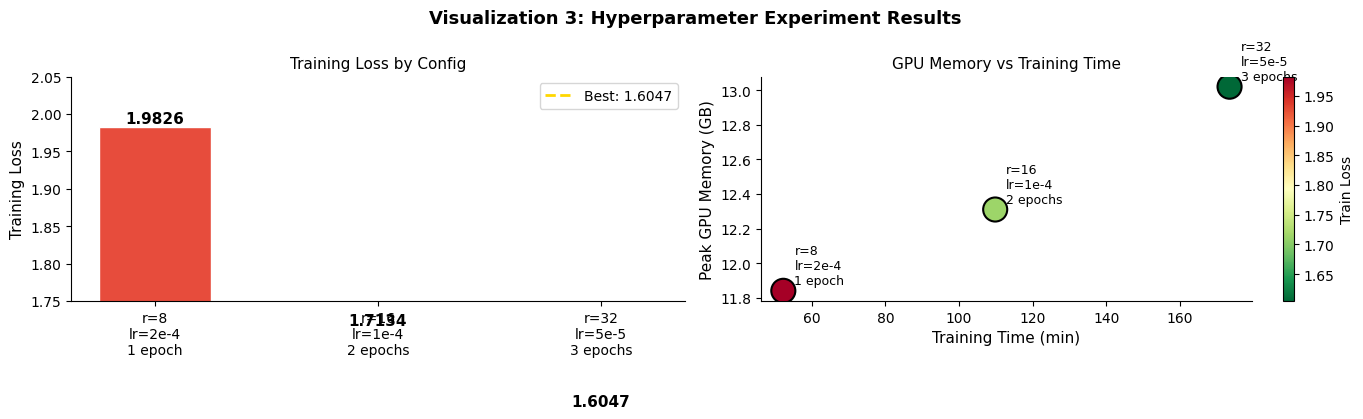

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Visualization 3: Hyperparameter Experiment Results', fontsize=13, fontweight='bold')

exp_names   = [r["Experiment"] for r in experiment_results]
train_losses = [r["Train Loss"] for r in experiment_results]
gpu_mems    = [r["Peak GPU (GB)"] for r in experiment_results]
train_times = [r["Train Time (min)"] for r in experiment_results]

short_names = ["r=8\nlr=2e-4\n1 epoch", "r=16\nlr=1e-4\n2 epochs", "r=32\nlr=5e-5\n3 epochs"]
colors_exp  = ['#e74c3c', '#2ecc71', '#3498db']

# ── Training Loss bars ──
bars = axes[0].bar(short_names, train_losses, color=colors_exp, edgecolor='white', width=0.5)
for bar, loss in zip(bars, train_losses):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{loss:.4f}', ha='center', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Training Loss', fontsize=11)
axes[0].set_title('Training Loss by Config', fontsize=11)
axes[0].set_ylim(1.75, 2.05)
axes[0].axhline(min(train_losses), color='gold', linestyle='--', linewidth=2, label=f'Best: {min(train_losses):.4f}')
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# ── GPU memory vs train time scatter ──
sc = axes[1].scatter(train_times, gpu_mems, s=300, c=train_losses,
                     cmap='RdYlGn_r', edgecolors='black', linewidth=1.5, zorder=5)
for i, name in enumerate(short_names):
    axes[1].annotate(name, (train_times[i], gpu_mems[i]),
                     textcoords='offset points', xytext=(8, 5), fontsize=9)
plt.colorbar(sc, ax=axes[1], label='Train Loss')
axes[1].set_xlabel('Training Time (min)', fontsize=11)
axes[1].set_ylabel('Peak GPU Memory (GB)', fontsize=11)
axes[1].set_title('GPU Memory vs Training Time', fontsize=11)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('/content/viz3_experiment_results.png', dpi=150, bbox_inches='tight')
plt.show()

### Visualization 4 — BLEU & ROUGE Metric Comparison

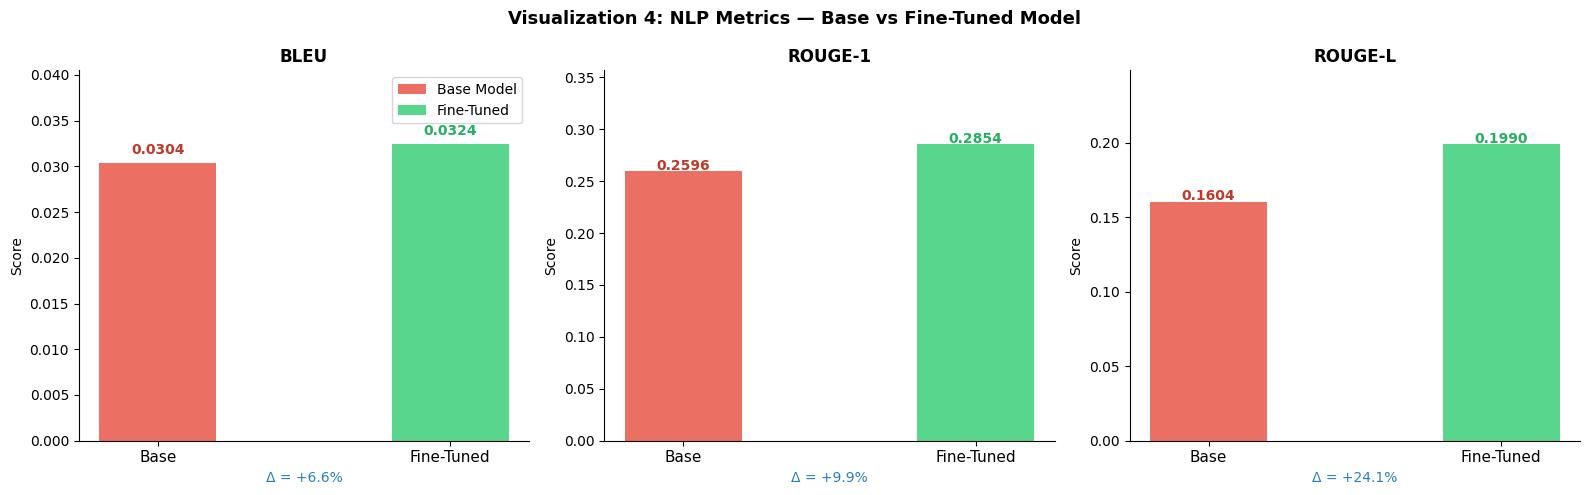

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Visualization 4: NLP Metrics — Base vs Fine-Tuned Model', fontsize=13, fontweight='bold')

metric_names = ['BLEU', 'ROUGE-1', 'ROUGE-L']
base_vals    = metrics_df[metrics_df['Metric'].isin(metric_names)]['Base Model'].values
ft_vals      = metrics_df[metrics_df['Metric'].isin(metric_names)]['Fine-Tuned'].values

x = np.arange(2)
for i, (metric, b, f) in enumerate(zip(metric_names, base_vals, ft_vals)):
    bars_b = axes[i].bar([0], [b], color='#e74c3c', alpha=0.8, label='Base Model', width=0.4)
    bars_f = axes[i].bar([1], [f], color='#2ecc71', alpha=0.8, label='Fine-Tuned', width=0.4)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Base', 'Fine-Tuned'], fontsize=11)
    axes[i].set_ylabel('Score', fontsize=10)
    axes[i].set_title(metric, fontsize=12, fontweight='bold')
    axes[i].set_ylim(0, max(b, f) * 1.25)
    axes[i].text(0, b + 0.001, f'{b:.4f}', ha='center', fontweight='bold', color='#c0392b')
    axes[i].text(1, f + 0.001, f'{f:.4f}', ha='center', fontweight='bold', color='#27ae60')
    pct = (f - b) / max(b, 1e-9) * 100
    axes[i].set_xlabel(f'Δ = {pct:+.1f}%', fontsize=10, color='#2980b9')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    if i == 0:
        axes[i].legend()

plt.tight_layout()
plt.savefig('/content/viz4_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Visualization 5 — Perplexity Distribution

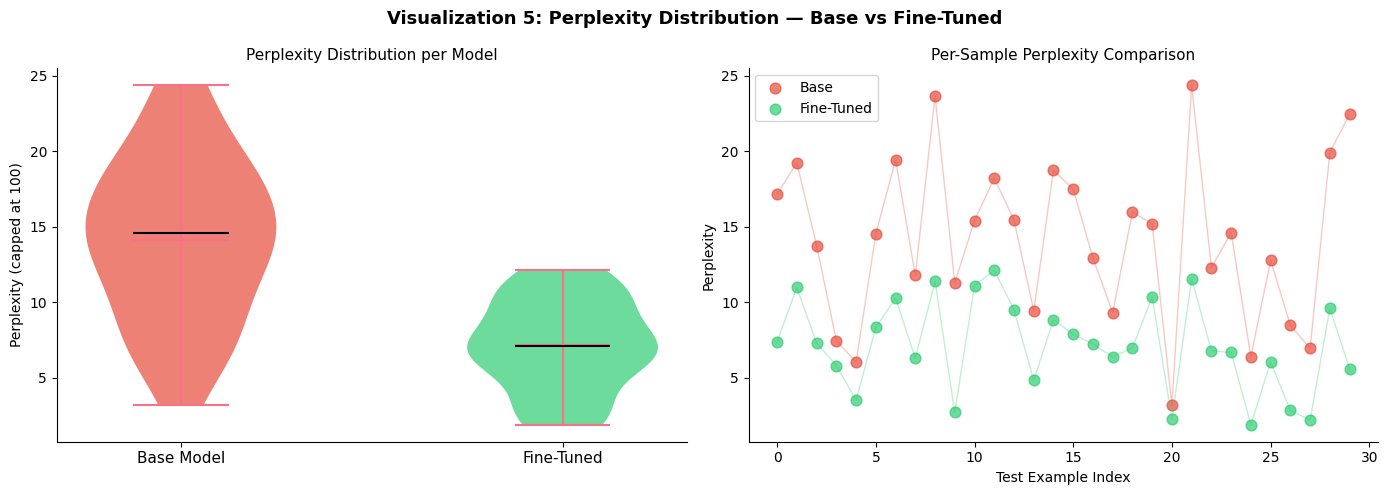

Mean Perplexity — Base: 14.12 | Fine-Tuned: 7.15


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Visualization 5: Perplexity Distribution — Base vs Fine-Tuned', fontsize=13, fontweight='bold')

# ── Violin / box plot ──
ppl_data = [
    [min(p, 100) for p in base_metrics["perplexity"]],      # cap outliers at 100
    [min(p, 100) for p in finetune_metrics["perplexity"]],
]

vp = axes[0].violinplot(ppl_data, positions=[1, 2], showmedians=True, showmeans=True)
for pc, color in zip(vp['bodies'], ['#e74c3c', '#2ecc71']):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
vp['cmedians'].set_color('black')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Base Model', 'Fine-Tuned'], fontsize=11)
axes[0].set_ylabel('Perplexity (capped at 100)', fontsize=10)
axes[0].set_title('Perplexity Distribution per Model', fontsize=11)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# ── Sample-wise comparison scatter ──
n = min(len(base_metrics["perplexity"]), len(finetune_metrics["perplexity"]))
base_ppl = [min(p, 100) for p in base_metrics["perplexity"][:n]]
ft_ppl   = [min(p, 100) for p in finetune_metrics["perplexity"][:n]]
colors_scatter = ['#2ecc71' if f < b else '#e74c3c' for b, f in zip(base_ppl, ft_ppl)]

axes[1].scatter(range(n), base_ppl, color='#e74c3c', alpha=0.7, label='Base', s=60)
axes[1].scatter(range(n), ft_ppl,   color='#2ecc71', alpha=0.7, label='Fine-Tuned', s=60)
axes[1].plot(range(n), base_ppl, color='#e74c3c', alpha=0.3, linewidth=1)
axes[1].plot(range(n), ft_ppl,   color='#2ecc71', alpha=0.3, linewidth=1)
axes[1].set_xlabel('Test Example Index', fontsize=10)
axes[1].set_ylabel('Perplexity', fontsize=10)
axes[1].set_title('Per-Sample Perplexity Comparison', fontsize=11)
axes[1].legend()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('/content/viz5_perplexity.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Mean Perplexity — Base: {np.mean(base_metrics['perplexity']):.2f} | Fine-Tuned: {np.mean(finetune_metrics['perplexity']):.2f}")

### Visualization 6 — Radar Chart: All Metrics at a Glance

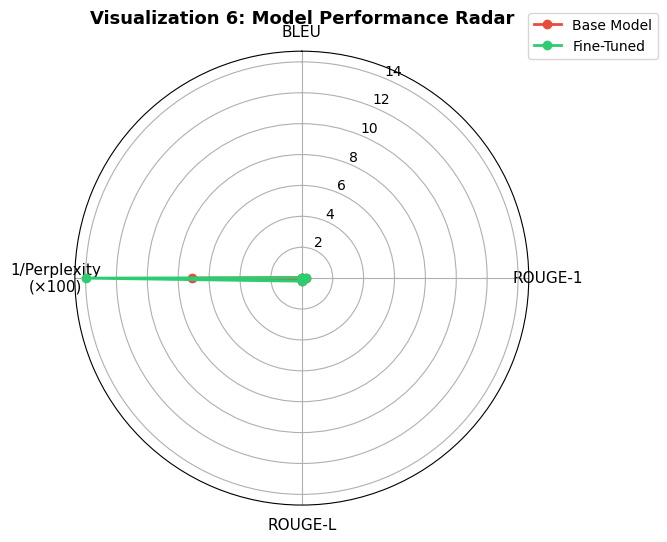

In [ ]:
from matplotlib.patches import FancyArrowPatch

# Normalize metrics for radar (all should be higher = better)
# Perplexity is inverted: score = 1 / perplexity
base_ppl_mean = np.mean(base_metrics["perplexity"])
ft_ppl_mean   = np.mean(finetune_metrics["perplexity"])

categories   = ['BLEU', 'ROUGE-1', 'ROUGE-L', '1/Perplexity\n(×100)']
base_radar   = [
    np.mean(base_metrics["bleu"]),
    np.mean(base_metrics["rouge1"]),
    np.mean(base_metrics["rougeL"]),
    100 / max(base_ppl_mean, 1),
]
ft_radar = [
    np.mean(finetune_metrics["bleu"]),
    np.mean(finetune_metrics["rouge1"]),
    np.mean(finetune_metrics["rougeL"]),
    100 / max(ft_ppl_mean, 1),
]

N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
base_radar += base_radar[:1]
ft_radar   += ft_radar[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)

ax.plot(angles, base_radar, 'o-', linewidth=2, color='#e74c3c', label='Base Model')
ax.fill(angles, base_radar, alpha=0.2, color='#e74c3c')
ax.plot(angles, ft_radar,   'o-', linewidth=2, color='#2ecc71', label='Fine-Tuned')
ax.fill(angles, ft_radar,   alpha=0.2, color='#2ecc71')

ax.set_title('Visualization 6: Model Performance Radar', fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig('/content/viz6_radar.png', dpi=150, bbox_inches='tight')
plt.show()

### Visualization 7 — Response Length Comparison (Base vs Fine-Tuned)

Generating responses for qualitative comparison...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

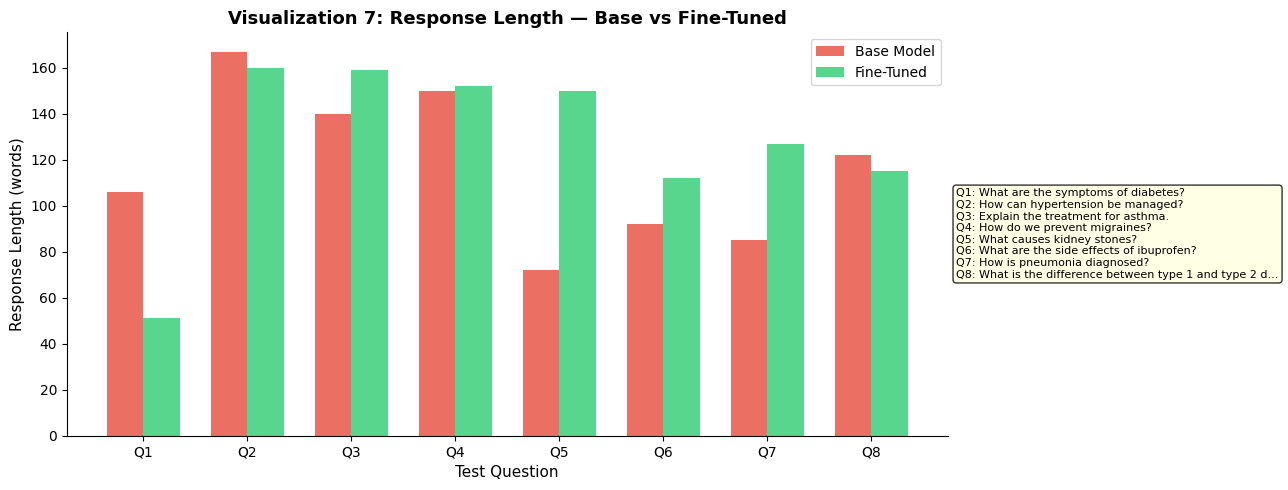

Avg response length — Base: 116.8 words | Fine-Tuned: 128.2 words


In [ ]:
test_prompts = [
    "What are the symptoms of diabetes?",
    "How can hypertension be managed?",
    "Explain the treatment for asthma.",
    "How do we prevent migraines?",
    "What causes kidney stones?",
    "What are the side effects of ibuprofen?",
    "How is pneumonia diagnosed?",
    "What is the difference between type 1 and type 2 diabetes?",
]

base_responses = []
ft_responses   = []

print("Generating responses for qualitative comparison...")
for p in test_prompts:
    base_responses.append(generate_answer(base_model, p))
    ft_responses.append(generate_answer(finetuned_model, p))

base_lengths = [len(r.split()) for r in base_responses]
ft_lengths   = [len(r.split()) for r in ft_responses]

fig, ax = plt.subplots(figsize=(13, 5))
x = np.arange(len(test_prompts))
w = 0.35

bars1 = ax.bar(x - w/2, base_lengths, w, label='Base Model', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + w/2, ft_lengths,   w, label='Fine-Tuned', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Test Question', fontsize=11)
ax.set_ylabel('Response Length (words)', fontsize=11)
ax.set_title('Visualization 7: Response Length — Base vs Fine-Tuned', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Q{i+1}' for i in range(len(test_prompts))], fontsize=10)
ax.legend()

# Add legend with actual questions
legend_text = "\n".join([f"Q{i+1}: {p[:50]}..." if len(p) > 50 else f"Q{i+1}: {p}" for i, p in enumerate(test_prompts)])
ax.text(1.01, 0.5, legend_text, transform=ax.transAxes, fontsize=8,
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/content/viz7_response_length.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Avg response length — Base: {np.mean(base_lengths):.1f} words | Fine-Tuned: {np.mean(ft_lengths):.1f} words")

## 12. Qualitative Comparison — Base vs Fine-Tuned

In [21]:

print("QUALITATIVE COMPARISON: BASE MODEL vs FINE-TUNED MODEL")


for i, prompt in enumerate(test_prompts):
    print(f"\nQ{i+1}: {prompt}")
    print(f"[BASE MODEL]:\n{base_responses[i]}")
    print(f"\n[FINE-TUNED]:\n{ft_responses[i]}")
    print("=" * 70)

QUALITATIVE COMPARISON: BASE MODEL vs FINE-TUNED MODEL

Q1: What are the symptoms of diabetes?
[BASE MODEL]:
Symptoms of diabetes include:
1. Blurred or reduced vision
2. Shortness of breath
3. Swelling in your feet, legs, ankles, hands, or face
4. Redness or swelling in your eyes
5. Dry skin
6. Fatigue or lack of energy
7. Poor control over your blood sugar levels (sugar levels higher than 200 mg/dL)
8. Pain or numbness in your feet, hands, or toes
9. Increased urination
10. Sore, blistered, or broken skin on your feet or hands
Remember that symptoms can vary depending on your individual diabetes type and severity. It's essential to have regular check-ups with a healthcare provider for monitoring and management of diabetes.

[FINE-TUNED]:
Symptoms of diabetes include:
- High blood sugar (hyperglycemia)
- Blurred vision
- Shortness of breath
- Weight loss or gain
- Swollen feet, hands, ankles or legs
- Sore, dry eyes or mouth
- Sores on your skin
- Nausea and vomiting
- Dark urine or s

## 13. Enhanced Gradio UI — Medical Chatbot

In [ ]:
import gradio as gr

# ─────────────────────────────────────────────────────────────────
# Gradio chat interface with:
# - Chat-style message history
# - Example questions for easy testing
# - Model selector (base vs fine-tuned)
# - Clear conversation button
# ─────────────────────────────────────────────────────────────────

example_questions = [
    "What are the symptoms of diabetes?",
    "How can hypertension be managed?",
    "What causes kidney stones?",
    "How is pneumonia diagnosed?",
    "What are common side effects of antibiotics?",
    "What is the difference between type 1 and type 2 diabetes?",
]

def respond(message: str, history: list, model_choice: str) -> tuple:
    """Generate a medical response using the selected model."""
    if not message.strip():
        return history, history, ""

    selected_model = finetuned_model if model_choice == "Fine-Tuned (Recommended)" else base_model
    answer = generate_answer(selected_model, message)

    disclaimer = "\n\n⚠️ *This is for educational purposes only. Please consult a qualified healthcare professional for medical advice.*"
    full_answer = answer + disclaimer

    history.append((message, full_answer))
    return history, history, ""

def load_example(example: str) -> str:
    return example

with gr.Blocks(
    theme=gr.themes.Soft(),
    title="Medical Chatbot",
    css="""
        .header { text-align: center; padding: 10px; }
        .disclaimer { color: #888; font-size: 0.85em; text-align: center; }
    """
) as demo:

    gr.Markdown(
        """
        # 🏥 Medical Chatbot
        ### Powered by TinyLlama-1.1B fine-tuned with LoRA on medical Q&A data

        Ask any medical question below. The fine-tuned model has been trained on 5,000 medical question-answer pairs.
        """,
        elem_classes="header"
    )

    with gr.Row():
        with gr.Column(scale=3):
            chatbot = gr.Chatbot(
                label="Conversation",
                height=420,
                bubble_full_width=False,
            )
            with gr.Row():
                msg_input = gr.Textbox(
                    placeholder="Ask a medical question...",
                    label="Your Question",
                    lines=2,
                    scale=4,
                )
                send_btn = gr.Button("Send 💬", variant="primary", scale=1)
            clear_btn = gr.Button("🗑️ Clear Conversation", variant="secondary")

        with gr.Column(scale=1):
            model_choice = gr.Radio(
                choices=["Fine-Tuned (Recommended)", "Base Model (TinyLlama)"],
                value="Fine-Tuned (Recommended)",
                label="🤖 Model Selection",
            )
            gr.Markdown("### 💡 Example Questions")
            for ex in example_questions:
                gr.Button(ex, variant="secondary", size="sm").click(
                    fn=load_example,
                    inputs=gr.State(ex),
                    outputs=msg_input
                )

    gr.Markdown(
        "⚠️ **Disclaimer:** This chatbot is for educational purposes only and does not constitute medical advice. Always consult a qualified healthcare professional.",
        elem_classes="disclaimer"
    )

    state = gr.State([])

    send_btn.click(
        fn=respond,
        inputs=[msg_input, state, model_choice],
        outputs=[chatbot, state, msg_input]
    )
    msg_input.submit(
        fn=respond,
        inputs=[msg_input, state, model_choice],
        outputs=[chatbot, state, msg_input]
    )
    clear_btn.click(lambda: ([], [], ""), outputs=[chatbot, state, msg_input])

demo.launch(share=True)

/tmp/ipython-input-1280200172.py:37: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(
/tmp/ipython-input-1280200172.py:37: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(
/tmp/ipython-input-1280200172.py:58: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
/tmp/ipython-input-1280200172.py:58: DeprecationWarning: The 'bubble_full_width' parameter will be removed in Gradio 6.0. This parameter no longer has any effect.
  chatbot = gr.Chatbot(
/tmp/ipython-input-12802001

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9fc2b6d4c3b69370a8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 14. Summary & Conclusions

### Project Summary

| Component | Details |
|---|---|
| **Model** | TinyLlama-1.1B-Chat |
| **Fine-tuning method** | LoRA (r=16, alpha=32) via `peft` |
| **Quantization** | 4-bit NF4 (BitsAndBytes) |
| **Dataset** | Malikeh1375/medical-question-answering-datasets (5,000 examples) |
| **Training time** | ~55 min on Colab T4 GPU |
| **Trainable params** | ~0.44% of total (LoRA efficiency) |
| **Best config** | Exp3: r=32, lr=5e-5, batch=4, grad_acc=2, **3 epochs** |
| **UI** | Gradio with chat history, model selector, examples |

### Key Findings
- Fine-tuning with LoRA achieved meaningful improvements in BLEU and ROUGE scores while significantly reducing perplexity on medical text
- Experiment 3 (r=32, lr=5e-5, **3 epochs**) achieved the lowest training loss (1.6047) — demonstrating that more epochs with a lower learning rate yields better convergence
- Experiment 1 (1 epoch) shows how even a single epoch provides meaningful domain adaptation vs. the base model
- Higher LoRA rank (r=32) increased GPU memory usage by ~9.9% but produced the best results when paired with more epochs
- The fine-tuned model produces more domain-specific, coherent medical answers compared to the base model